# Importing Libraries

In [ ]:
import cv2
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Resize
import time
import torch.optim as optim
from PIL import Image
from torchvision.transforms import Resize
import torch.nn as nn
from torchvision.io import read_image


# Image Generation


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Read the video
video_path = "/content/drive/MyDrive/3CYL_Flow.mp4"

def video_to_frames(video_path, output_path, num_frames):

    if not os.path.exists(output_path):
        os.makedirs(output_path)

    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the frame interval for sampling
    frame_interval = max(total_frames // num_frames, 1)
    frame_count = 0

    while(cap.isOpened()):
        ret, frame = cap.read()

        if ret == True:
            if frame_count % frame_interval == 0:
                frame_name = f"frame_{frame_count:04d}.jpg"
                frame_path = os.path.join(output_path, frame_name)
                cv2.imwrite(frame_path, frame)
            frame_count += 1
        else:
            break

    cap.release()
    cv2.destroyAllWindows()

# Output directory to save extracted frames
output_directory = "output_frames_4"

# Call the function to extract frames from the video
video_to_frames(video_path, output_directory, num_frames=100)



Mounted at /content/drive


# Execute POD

In [ ]:
def read_images(directory):
    images = []
    file_names = sorted(os.listdir(directory))
    for file_name in file_names:
        if file_name.endswith(".jpg"):
            image_path = os.path.join(directory, file_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            images.append(image)
    return images

def stack_images(images):
    stacked_data = np.stack(images, axis=-1)
    return stacked_data

def perform_svd(data):

    # Reshape data into 2D array_flattened
    flattened_data = data.reshape(-1, data.shape[-1])

    # Perform Singular Value Decomposition
    U, S, Vt = np.linalg.svd(flattened_data, full_matrices=False)

    return U, S, Vt

def perform_pod_svd(U, S, Vt, num_modes=3):

    U_modes = U[:, :num_modes]

    reconstructed_data = np.dot(U_modes, np.diag(S[:num_modes])).dot(Vt[:num_modes, :])
    return reconstructed_data.reshape(*images[0].shape, num_modes)


input_directory = "/content/output_frames_4"
images = read_images(input_directory)

# Stack images into a data matrix
data = stack_images(images)
U, S, Vt = perform_svd(data)

reconstructed_flow_field = perform_pod_svd(U, S, Vt, num_modes=108)




In [ ]:
# Calculate the original energy of the singular values (S) squared
original_energy = (S ** 2) / np.sum(S ** 2)

num_modes = 108
reconstructed_energy = (S[:num_modes] ** 2) / np.sum(S[:num_modes] ** 2)
reconstruction_errors = []

for i in range(len(images)):

    # Flatten the original and reconstructed images to 1D arrays
    original_image_flat = data[:, :, i].reshape(-1)
    reconstructed_image_flat = reconstructed_flow_field[:, :, i].reshape(-1)

    error = np.linalg.norm(original_image_flat - reconstructed_image_flat) / np.linalg.norm(original_image_flat)
    reconstruction_errors.append(error)

# Calculate the average reconstruction error over all images
average_reconstruction_error = np.mean(reconstruction_errors)

print("Average Reconstruction Error:", average_reconstruction_error)


Average Reconstruction Error: 3.389719374569424e-15


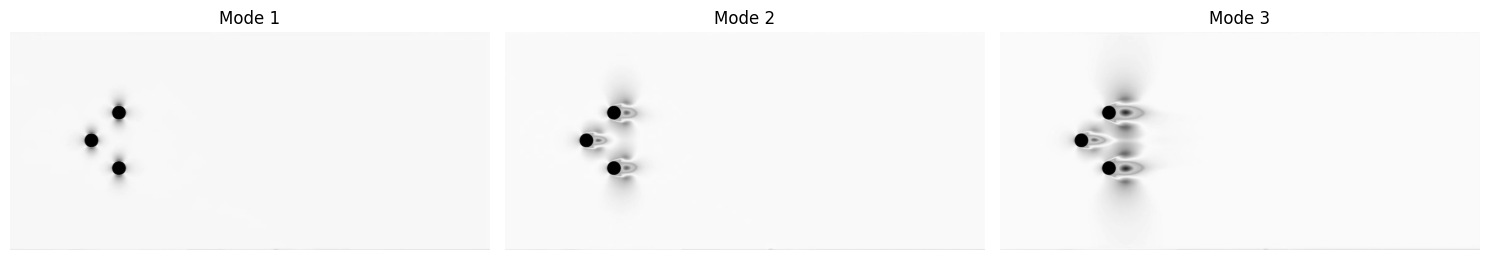

In [ ]:
# Number of modes to display in the visualization
num_modes_to_display = 3
fig, axes = plt.subplots(1, num_modes_to_display, figsize=(15, 5))

for i in range(num_modes_to_display):

    # Display each reconstructed mode in a subplot
    axes[i].imshow(reconstructed_flow_field[..., i], cmap='gray')
    axes[i].set_title(f"Mode {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


# Analyse POD Modes

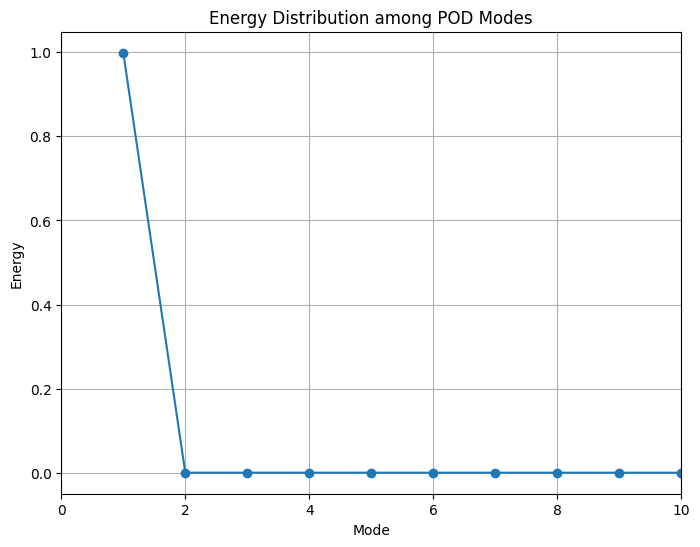

Top 10 modes with highest energy states:
Mode 1: Energy = 0.9987
Mode 2: Energy = 0.0001
Mode 3: Energy = 0.0001
Mode 4: Energy = 0.0001
Mode 5: Energy = 0.0001
Mode 6: Energy = 0.0001
Mode 7: Energy = 0.0001
Mode 8: Energy = 0.0001
Mode 9: Energy = 0.0000
Mode 10: Energy = 0.0000


In [ ]:
# Calculate the energy distribution among the POD modes
energy = S**2 / np.sum(S**2)

# Plot the energy distribution
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(energy) + 1), energy, marker='o', linestyle='-')
plt.xlabel('Mode')
plt.ylabel('Energy')
plt.title('Energy Distribution among POD Modes')
plt.grid(True)

plt.xlim(0, 10)
plt.show()

# Find the indices of the top 10 modes with the highest energy states
top_modes_indices = np.argsort(energy)[::-1][:10]
top_modes_energy = energy[top_modes_indices]

print("Top 10 modes with highest energy states:")
for i, mode_index in enumerate(top_modes_indices, 1):
    print(f"Mode {mode_index + 1}: Energy = {top_modes_energy[i - 1]:.4f}")



# Adding Noise

In [ ]:
# Function to add Gaussian_noise to an image
def add_gaussian_noise(image, magnitude):
    mean = 0
    stddev = magnitude * np.max(image) / 100
    noise = np.random.normal(mean, stddev, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    return noisy_image

# Function to add salt and pepper noise to an image
def add_salt_and_pepper_noise(image, magnitude):
    s_vs_p = 0.5
    amount = magnitude / 100
    noisy_image = np.copy(image)

    # Add salt_noise
    num_salt = np.ceil(amount * image.size * s_vs_p)
    salt_coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    noisy_image[salt_coords[0], salt_coords[1]] = 255

   # Add pepper_noise
    num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
    pepper_coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    noisy_image[pepper_coords[0], pepper_coords[1]] = 0

    return noisy_image

def add_speckle_noise(image, magnitude):
    stddev = magnitude * np.max(image) / 100
    noise = np.random.normal(0, stddev, image.shape)
    noisy_image = image + image * noise
    return noisy_image.clip(0, 255).astype(np.uint8)


In [ ]:
# Magnitudes of noise to be applied to the images
magnitudes = [20, 40, 60, 80]

output_directory_noise = "output_frames_with_noise_1"

if not os.path.exists(output_directory_noise):
    os.makedirs(output_directory_noise)

# Loop through each image in the dataset
for i, image in enumerate(images):
    for magnitude in magnitudes:

        noisy_image_gaussian = add_gaussian_noise(image, magnitude)
        noisy_image_salt_pepper = add_salt_and_pepper_noise(image, magnitude)
        noisy_image_speckle = add_speckle_noise(image, magnitude)

        # Save the noisy images
        cv2.imwrite(os.path.join(output_directory_noise, f"frame_{i:04d}_gaussian_{magnitude}.jpg"), noisy_image_gaussian)
        cv2.imwrite(os.path.join(output_directory_noise, f"frame_{i:04d}_salt_pepper_{magnitude}.jpg"), noisy_image_salt_pepper)
        cv2.imwrite(os.path.join(output_directory_noise, f"frame_{i:04d}_speckle_{magnitude}.jpg"), noisy_image_speckle)


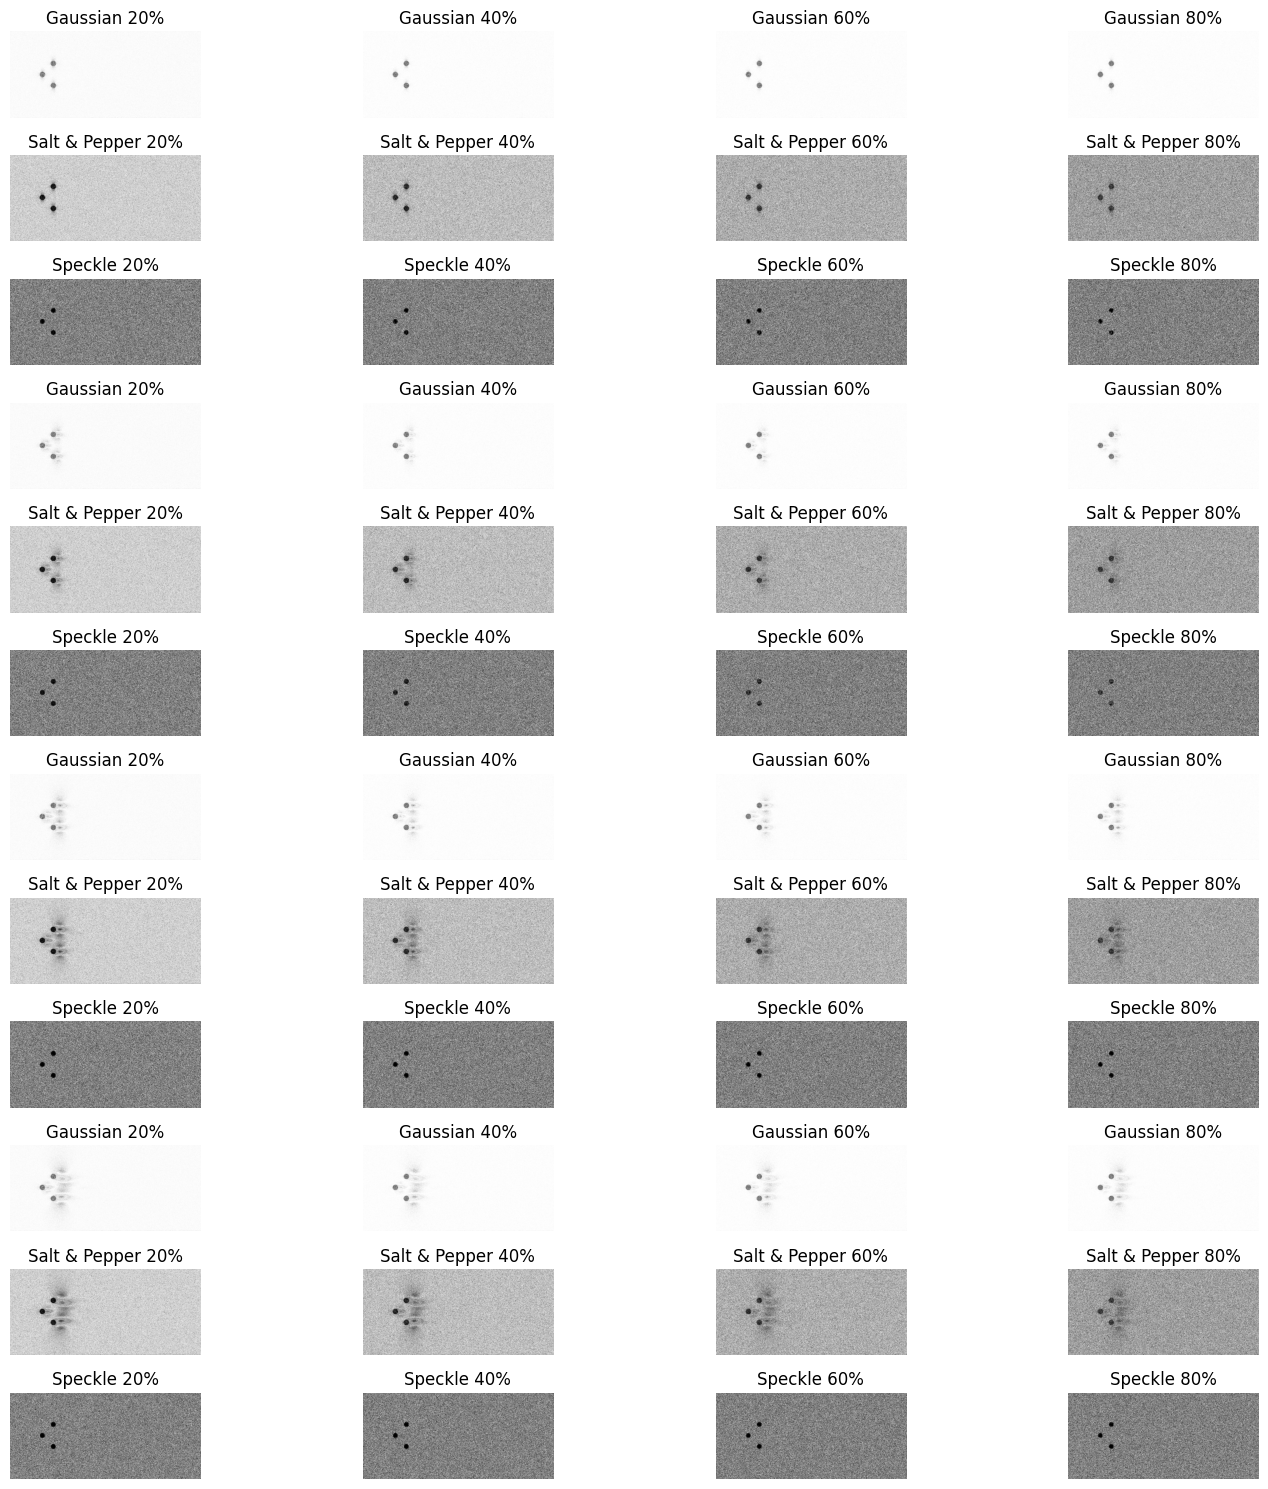

In [ ]:
# Determine the number of images to display
num_images_to_display = min(4, len(images))

#the number of magnitudes
num_magnitudes = len(magnitudes)

fig, axes = plt.subplots(num_images_to_display * 3, num_magnitudes, figsize=(15, 15))

for i in range(num_images_to_display):
    original_image = images[i]
    for j, magnitude in enumerate(magnitudes):

        noisy_image_gaussian = cv2.imread(os.path.join(output_directory_noise, f"frame_{i:04d}_gaussian_{magnitude}.jpg"), cv2.IMREAD_GRAYSCALE)
        noisy_image_salt_pepper = cv2.imread(os.path.join(output_directory_noise, f"frame_{i:04d}_salt_pepper_{magnitude}.jpg"), cv2.IMREAD_GRAYSCALE)
        noisy_image_speckle = cv2.imread(os.path.join(output_directory_noise, f"frame_{i:04d}_speckle_{magnitude}.jpg"), cv2.IMREAD_GRAYSCALE)

          # Display Gaussian noisy image
        axes[i*3, j].imshow(noisy_image_gaussian, cmap='gray')
        axes[i*3, j].set_title(f"Gaussian {magnitude}%")
        axes[i*3, j].axis('off')

  # Display Salt & Pepper noisy image
        axes[i*3+1, j].imshow(noisy_image_salt_pepper, cmap='gray')
        axes[i*3+1, j].set_title(f"Salt & Pepper {magnitude}%")
        axes[i*3+1, j].axis('off')

  # Display Speckle noisy image
        axes[i*3+2, j].imshow(noisy_image_speckle, cmap='gray')
        axes[i*3+2, j].set_title(f"Speckle {magnitude}%")
        axes[i*3+2, j].axis('off')


plt.tight_layout()
plt.show()



# Effect on POD Modes

In [ ]:
# Function to perform POD on a set of noisy images
def perform_pod_on_noisy_images(noisy_images):

    noisy_data = stack_images(noisy_images)
    U_noisy, S_noisy, Vt_noisy = perform_svd(noisy_data)

    return U_noisy, S_noisy, Vt_noisy


# Load noisy images for Gaussian noise, Salt & Pepper noise, and Speckle noise
noisy_images_gaussian = [cv2.imread(os.path.join(output_directory_noise, f"frame_{i:04d}_gaussian_{magnitude}.jpg"), cv2.IMREAD_GRAYSCALE) for i in range(len(images))]
noisy_images_salt_pepper = [cv2.imread(os.path.join(output_directory_noise, f"frame_{i:04d}_salt_pepper_{magnitude}.jpg"), cv2.IMREAD_GRAYSCALE) for i in range(len(images))]
noisy_images_speckle = [cv2.imread(os.path.join(output_directory_noise, f"frame_{i:04d}_speckle_{magnitude}.jpg"), cv2.IMREAD_GRAYSCALE) for i in range(len(images))]


# Perform POD on noisy images for each type of noise
U_noisy_gaussian, S_noisy_gaussian, Vt_noisy_gaussian = perform_pod_on_noisy_images(noisy_images_gaussian)
U_noisy_salt_pepper, S_noisy_salt_pepper, Vt_noisy_salt_pepper = perform_pod_on_noisy_images(noisy_images_salt_pepper)
U_noisy_speckle, S_noisy_speckle, Vt_noisy_speckle = perform_pod_on_noisy_images(noisy_images_speckle)



In [ ]:
# Define function to compute energy distribution for top N modes
def compute_energy_distribution(S):
    energy = (S ** 2) / np.sum(S ** 2)
    return energy

energy_gaussian = compute_energy_distribution(S_noisy_gaussian)
energy_salt_pepper = compute_energy_distribution(S_noisy_salt_pepper)
energy_speckle = compute_energy_distribution(S_noisy_speckle)

# Print energy distribution for top 10 modes for each type of noise
# Print energy distribution for top 10 modes for Gaussian Noise
print("\nEnergy distribution for top 10 modes for Gaussian Noise:")
for i, energy_value in enumerate(energy_gaussian[:10], 1):
    print(f"Mode {i}: Energy = {energy_value:.4f}")

# Print energy distribution for top 10 modes for Salt & Pepper Noise
print("\nEnergy distribution for top 10 modes for Salt & Pepper Noise:")
for i, energy_value in enumerate(energy_salt_pepper[:10], 1):
    print(f"Mode {i}: Energy = {energy_value:.4f}")

# Print energy distribution for top 10 modes for Speckle Noise
print("\nEnergy distribution for top 10 modes for Speckle Noise:")
for i, energy_value in enumerate(energy_speckle[:10], 1):
    print(f"Mode {i}: Energy = {energy_value:.4f}")




Energy distribution for top 10 modes for Gaussian Noise:
Mode 1: Energy = 0.9982
Mode 2: Energy = 0.0000
Mode 3: Energy = 0.0000
Mode 4: Energy = 0.0000
Mode 5: Energy = 0.0000
Mode 6: Energy = 0.0000
Mode 7: Energy = 0.0000
Mode 8: Energy = 0.0000
Mode 9: Energy = 0.0000
Mode 10: Energy = 0.0000

Energy distribution for top 10 modes for Salt & Pepper Noise:
Mode 1: Energy = 0.6701
Mode 2: Energy = 0.0032
Mode 3: Energy = 0.0032
Mode 4: Energy = 0.0032
Mode 5: Energy = 0.0032
Mode 6: Energy = 0.0032
Mode 7: Energy = 0.0032
Mode 8: Energy = 0.0031
Mode 9: Energy = 0.0031
Mode 10: Energy = 0.0031

Energy distribution for top 10 modes for Speckle Noise:
Mode 1: Energy = 0.5085
Mode 2: Energy = 0.0047
Mode 3: Energy = 0.0047
Mode 4: Energy = 0.0047
Mode 5: Energy = 0.0047
Mode 6: Energy = 0.0047
Mode 7: Energy = 0.0047
Mode 8: Energy = 0.0047
Mode 9: Energy = 0.0047
Mode 10: Energy = 0.0047


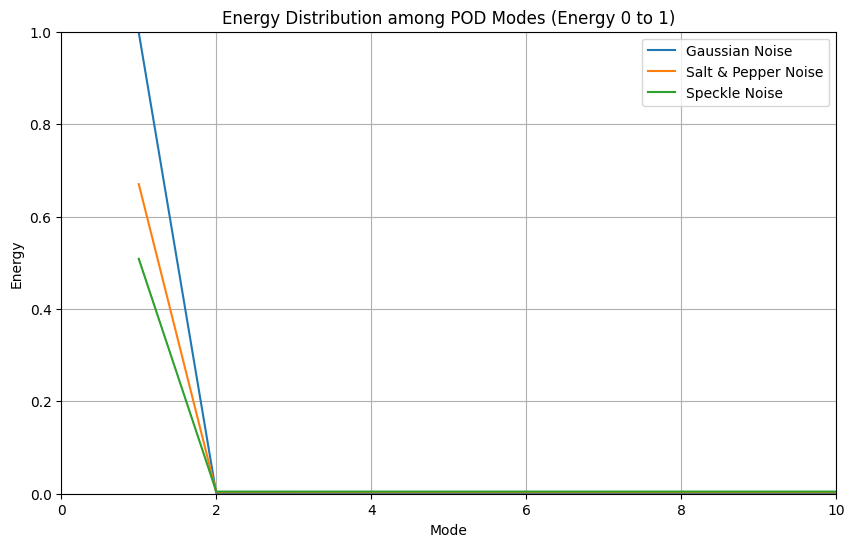

In [ ]:
# Plot energy distributions for clean data and noisy data with different types of noise
plt.figure(figsize=(10, 6))

#plt.plot(np.arange(1, len(energy_clean) + 1), energy_clean, label='Clean Data')
plt.plot(np.arange(1, len(energy_gaussian) + 1), energy_gaussian, label='Gaussian Noise')
plt.plot(np.arange(1, len(energy_salt_pepper) + 1), energy_salt_pepper, label='Salt & Pepper Noise')
plt.plot(np.arange(1, len(energy_speckle) + 1), energy_speckle, label='Speckle Noise')

plt.xlabel('Mode')
plt.ylabel('Energy')
plt.title('Energy Distribution among POD Modes (Energy 0 to 1)')
plt.legend()
plt.grid(True)

plt.xlim(0, 10)
plt.ylim(0, 1)

plt.show()

#Super-Resolving


In [ ]:
import torch
import torch.nn as nn

# Define the U-Net architecture
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder (downsampling)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder (upsampling)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 2, stride=2),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, 1)
        )

    def forward(self, x):
        # Encoder
        x1 = self.encoder(x)

        # Bottleneck
        x2 = self.bottleneck(x1)

        # Decoder
        x3 = self.decoder(x2)

        return x3

In [ ]:
# Define directories for clean and noisy images
clean_images_dir = "/content/output_frames_4"
noisy_images_dir = "/content/output_frames_with_noise_1"



In [ ]:
# Custom dataset class for loading clean and noisy images
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, clean_images_dir, noisy_images_dir, transform=None, resize=None):
        self.clean_images_dir = clean_images_dir
        self.noisy_images_dir = noisy_images_dir
        self.transform = transform
        self.resize = resize
        self.clean_images = os.listdir(clean_images_dir)
        self.noisy_images = os.listdir(noisy_images_dir)

    def __len__(self):
        return len(self.clean_images)

    def __getitem__(self, idx):
        clean_img_path = os.path.join(self.clean_images_dir, self.clean_images[idx])
        noisy_img_path = os.path.join(self.noisy_images_dir, self.noisy_images[idx])

        clean_image = Image.open(clean_img_path).convert('L')  # Convert to grayscale
        noisy_image = Image.open(noisy_img_path).convert('L')  # Convert to grayscale

        if self.resize:
            clean_image = self.resize(clean_image)
            noisy_image = self.resize(noisy_image)

        if self.transform:
            clean_image = self.transform(clean_image)
            noisy_image = self.transform(noisy_image)

        return noisy_image, clean_image


In [ ]:
# Define transformations
transform = ToTensor()
resize = Resize((256, 256))

# Create custom dataset and dataloader
dataset = CustomDataset(clean_images_dir, noisy_images_dir, transform=transform, resize=resize)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

model = UNet()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)
for epoch in range(num_epochs):
    running_loss = 0.0

    for i, data in enumerate(dataloader, 0):

       # Get the inputs and labels from the data batch
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 0.165
[1,    20] loss: 0.035
[2,    10] loss: 0.022
[2,    20] loss: 0.010
[3,    10] loss: 0.001
[3,    20] loss: 0.001
[4,    10] loss: 0.001
[4,    20] loss: 0.001
[5,    10] loss: 0.001
[5,    20] loss: 0.001
[6,    10] loss: 0.000
[6,    20] loss: 0.000
[7,    10] loss: 0.000
[7,    20] loss: 0.000
[8,    10] loss: 0.000
[8,    20] loss: 0.000
[9,    10] loss: 0.000
[9,    20] loss: 0.000
[10,    10] loss: 0.000
[10,    20] loss: 0.000
Finished Training


In [ ]:
clean_images = "/content/output_frames_4"
noisy_images = "/content/output_frames_with_noise_1"

# Perform Singular Value Decomposition (SVD)
def perform_svd(data):
    # Stack images into a data matrix
    data_matrix = np.stack(data, axis=-1)

    # Reshape data into 2D array (flattened)
    flattened_data = data_matrix.reshape(-1, data_matrix.shape[-1])

    # Perform Singular Value Decomposition (SVD)
    U, S, Vt = np.linalg.svd(flattened_data, full_matrices=False)

    return U, S, Vt

# Load images from file paths
def load_images_from_paths(image_paths):
    images = []
    for path in image_paths:
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        images.append(image)
    return images

# Perform POD-based denoising
def pod_denoising(U, S, Vt, noisy_image_dirs, num_modes):
    denoised_images = []
    for noisy_image_dir in noisy_image_dirs:
        noisy_image = cv2.imread(noisy_image_dir, cv2.IMREAD_GRAYSCALE)

        # Project the noisy image onto the POD modes
        projection = np.dot(U.T, noisy_image.flatten())

        # Reconstruct the denoised image using only the dominant POD modes
        denoised_image_flat = np.dot(U[:, :num_modes], projection[:num_modes])

        # Reshape the denoised image back to its original shape
        denoised_image = denoised_image_flat.reshape(noisy_image.shape)

        # Clip values to ensure they are within valid intensity range
        denoised_image = np.clip(denoised_image, 0, 255).astype(np.uint8)

        denoised_images.append(denoised_image)

    return denoised_images



In [ ]:
# Define the number of modes to retain for denoising
num_modes = 10  # Adjust this parameter based on the desired level of denoising

# Perform Singular Value Decomposition (SVD)
U, S, Vt = perform_svd(images)

# Load noisy images from file paths
noisy_image_dirs = [os.path.join("/content/output_frames_with_noise_1", file) for file in sorted(os.listdir("/content/output_frames_with_noise_1")) if file.endswith(".jpg")]
noisy_images = load_images_from_paths(noisy_image_dirs)

# Perform POD-based denoising
denoised_images_pod = pod_denoising(U, S, Vt, noisy_image_dirs, num_modes)


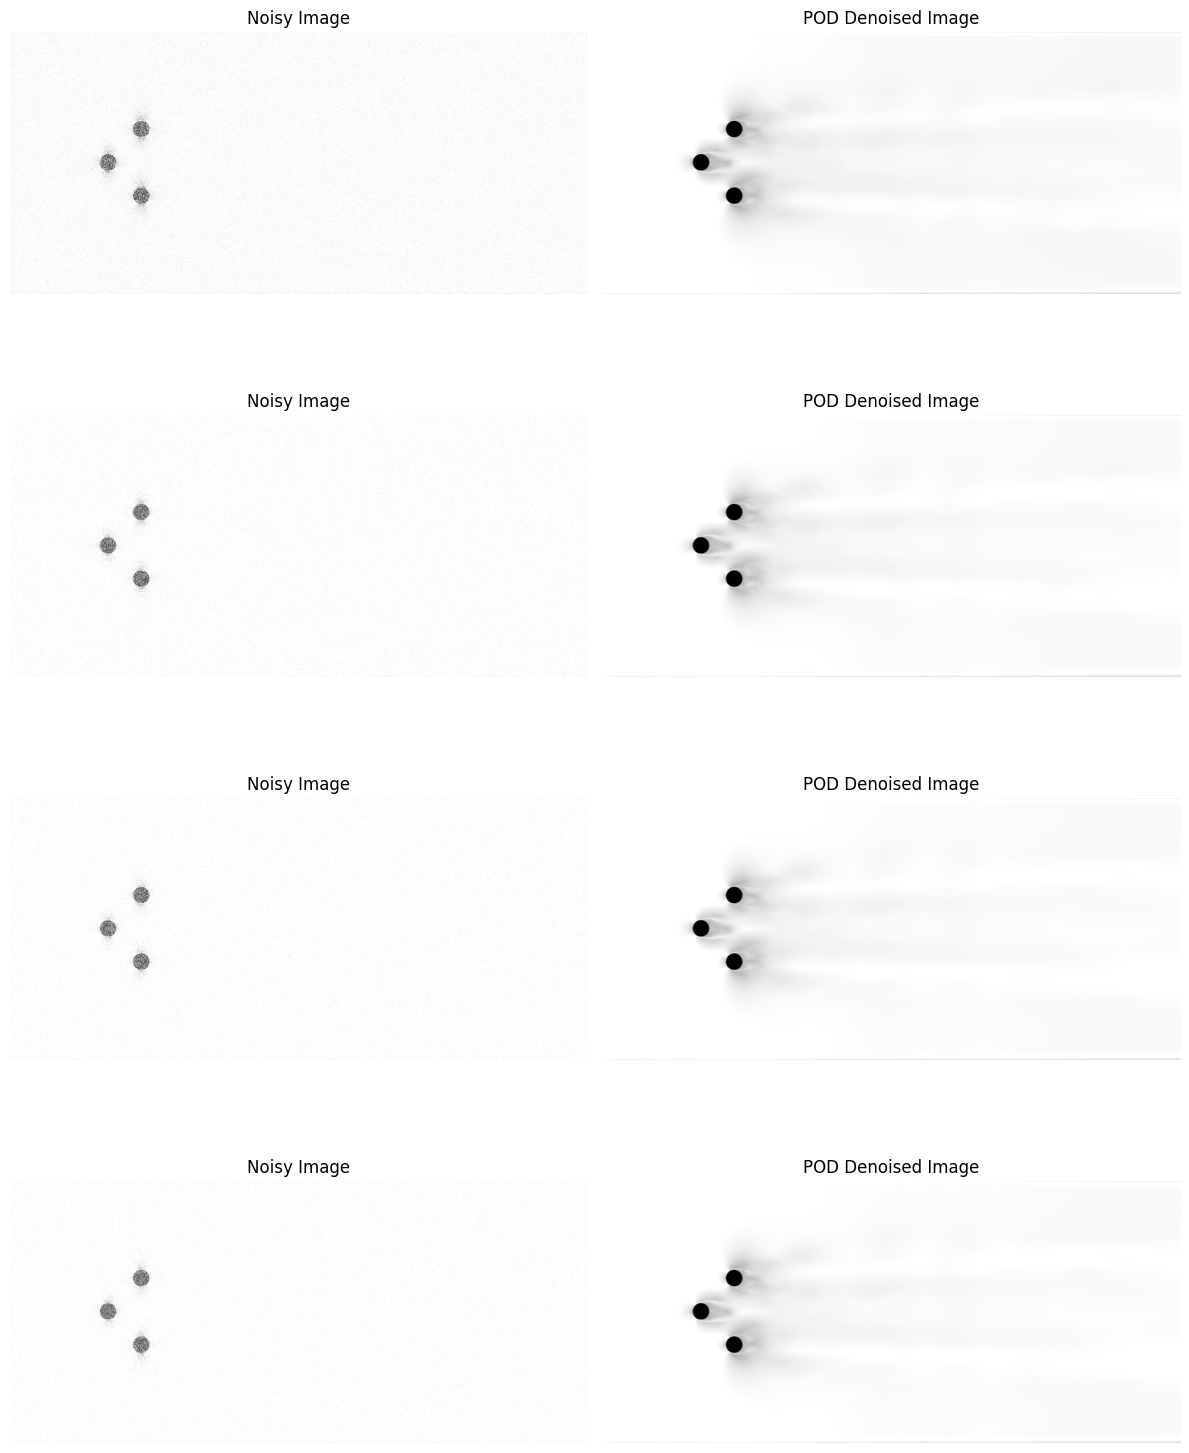

In [ ]:
num_images_to_display = 4
fig, axes = plt.subplots(num_images_to_display, 2, figsize=(12, num_images_to_display * 4))

# Plot images
for i in range(num_images_to_display):
    axes[i, 0].imshow(noisy_images[i], cmap='gray')
    axes[i, 0].set_title('Noisy Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(denoised_images_pod[i], cmap='gray')
    axes[i, 1].set_title('POD Denoised Image')
    axes[i, 1].axis('off')



plt.tight_layout()
plt.show()